<a href="https://colab.research.google.com/github/TrushitaD/Demo/blob/main/Toxic_LR_SVM_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn import decomposition, preprocessing
from scipy import sparse
import xgboost as xgb

In [5]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
test_label = pd.read_csv('/content/test_labels.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.shape, test.shape

((159571, 8), (153164, 2))

<Axes: >

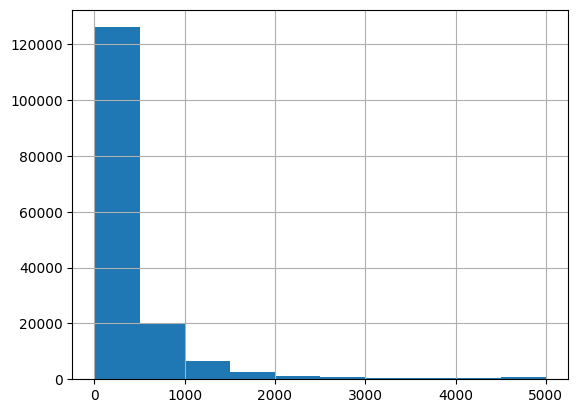

In [8]:
lens = train.comment_text.str.len()
lens.hist()

In [9]:
train["label_count"] = train["toxic"] + train["severe_toxic"] + train["obscene"] \
                        + train["threat"] + train["insult"] + train["identity_hate"]

In [10]:
len(train[train["label_count"] == 1]), len(train[train["label_count"] == 0]), len(train[train["label_count"] > 1])

(6360, 143346, 9865)

In [11]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [12]:
import re, string

alpha = 0.0001

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [13]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
                      min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True,
                      smooth_idf=True, sublinear_tf=True)
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
# count_vec = CountVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                             min_df=3, max_df=0.9, strip_accents='unicode', binary=True)
# trn_term_bi_doc = count_vec.fit_transform(train[COMMENT])
# test_term_bi_doc = count_vec.transform(test[COMMENT])
# # # Verify when TfidfVectorizer = 0, CountVectorizer = 0 => SUCCESS
# # set(np.array(vec.get_feature_names())[trn_term_doc[10,:].nonzero()[1]]) \
# #     - set(np.array(count_vec.get_feature_names())[trn_term_bi_doc[10,:].nonzero()[1]])

# ================
# The above method generate the SAME word index as that generated by TfidfVectorizer
# The following procedure is faster
trn_term_bi_doc = csr_matrix(trn_term_doc.shape, dtype=np.int8)
none_zero_mask = np.array(trn_term_doc[trn_term_doc.nonzero()]>0)[0]
rows = trn_term_doc.nonzero()[0][none_zero_mask]
cols = trn_term_doc.nonzero()[1][none_zero_mask]
trn_term_bi_doc[rows, cols] = 1

test_term_bi_doc = csr_matrix(test_term_doc.shape, dtype=np.int8)
none_zero_mask = np.array(test_term_doc[test_term_doc.nonzero()]>0)[0]
rows = test_term_doc.nonzero()[0][none_zero_mask]
cols = test_term_doc.nonzero()[1][none_zero_mask]
test_term_bi_doc[rows, cols] = 1
# # Verification
# print(set(trn_term_bi_doc.nonzero()[0]) - set(trn_term_doc.nonzero()[0]))
# print(set(trn_term_bi_doc.nonzero()[1]) - set(trn_term_doc.nonzero()[1]))
# print(set(test_term_bi_doc.nonzero()[0]) - set(test_term_doc.nonzero()[0]))
# print(set(test_term_bi_doc.nonzero()[1]) - set(test_term_doc.nonzero()[1]))a

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [15]:
def get_count(feature_x, y, label):
    index_label = (y == label).nonzero()[0]
    matrix_label = feature_x[index_label, :]
    count = matrix_label.sum(0) + alpha
    norm_count = count / np.linalg.norm(count, ord=1)
    return norm_count

In [16]:
def get_trained_model(model, feature_x, x, y):
    p_count = get_count(feature_x, y, 1)
    q_count = get_count(feature_x, y, 0)
    r = np.log(p_count / q_count)

    x_nb = x.multiply(r)
    if type(model).__name__ == "XGBClassifier":
        x_nb = x_nb.tocsc()
    return model.fit(x_nb, y), r

In [17]:
def get_accuracy(model, x_feature, x, test_x):
    correct_count = 0
    total_count = 0
    for i, j in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
        print('fit', j)
        y = train[j].values
        m,r = get_trained_model(model, x_feature, x, y)

        x_test_nb = test_x.multiply(r)
        if type(model).__name__ == "XGBClassifier":
            x_test_nb = x_test_nb.tocsc()

        y_pred = m.predict(x_test_nb)

        y_test = test_label[j].values
        graded_mask = y_test != -1
        correct_count += sum(y_test[graded_mask] == y_pred[graded_mask])
        total_count += len(y_test[graded_mask])
        print(correct_count, total_count)
    return (correct_count / total_count)

In [18]:
# TF-IDF feature, TF-IDF input with lr model
model = LogisticRegression(C=4, max_iter=500)
get_accuracy(model, trn_term_doc, trn_term_doc, test_term_doc)

fit toxic
59729 63978
fit severe_toxic
123174 127956
fit obscene
185003 191934
fit threat
248793 255912
fit insult
310452 319890
fit identity_hate
373845 383868


0.9738894620025634

In [19]:
# TF-IDF feature, TF-IDF input with svm model
model = LinearSVC(C=4, max_iter=1000)
get_accuracy(model, trn_term_doc, trn_term_doc, test_term_doc)

fit toxic


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


58468 63978
fit severe_toxic


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


121546 127956
fit obscene


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


182679 191934
fit threat


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


246431 255912
fit insult


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


307478 319890
fit identity_hate


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


370743 383868


0.9658085591922223

In [ ]:
# TF-IDF feature, TF-IDF input with xgboost model
model = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                          subsample=0.8, nthread=10, learning_rate=0.1)
get_accuracy(model, trn_term_doc, trn_term_doc, test_term_doc.tocsc())

fit toxic
